In [57]:
# Import all necessary libraries.
import numpy as np
from scipy.special import erfc
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV

In [58]:
# Number of BPSK symbols to be transmitted.
N = 1000000

In [59]:
mapping_table = [-1.0 +1j*0.0, 1.0 + 1j*0.]

def mod(bits):
    ip = np.zeros((len(bits),1),dtype=complex)
    inc = 0
    for v in bits:
        if(v==0):
            ip[inc] = mapping_table[0]
        else:
            ip[inc] = mapping_table[1]        
        inc += 1
        
    # Normalization of energy to 1.
    #s = (1/np.sqrt(10))*ip;
    s = ip
   
    return s

def demod(c):
    c_seq = mod(np.array([0,1]))
    c_seq = c_seq[:,0]
    e = []
    for i in range(0,len(c_seq)):
        e.append(np.abs(c_seq[i] - c)**2)
    return e.index(np.min(e))

In [60]:
# Create Es/N0 vector.
EsN0dB = np.arange(-10,12,2)

ser_simu = np.zeros(len(EsN0dB))
ser_theo = np.zeros(len(EsN0dB))
for idx in range(0,len(EsN0dB)):
    
    print('Es/N0 dB:', EsN0dB[idx])
    
    EsN0Lin = 10.0**(-(EsN0dB[idx]/10.0))
    
    # Generate N binary symbols.
    bits = np.random.randint(0,2,(N,1))
    
    # Modulate binary stream into BPSK symbols.
    s = mod(bits)
    s = s.reshape(N,1)
    bits = bits.reshape(N,1)
    
    # Generate noise vector. 
    # Divide by two once the theoretical ber uses a complex Normal pdf with variance of each part = 1/2.
    noise = np.sqrt(1.0/2.0)*(np.random.randn(N, 1) + 1j*np.random.randn(N, 1))
    
    # Pass symbols through AWGN channel.
    y = s + np.sqrt(EsN0Lin)*noise
    
    # Split array into random train and test subsets.
    s_test, s_train, y_test, y_train, bits_test, bits_train = train_test_split(s, y, bits, random_state=42)
    
    Y = np.c_[y_train.real,y_train.imag]
    
    # Create an instance of Neighbours Classifier and fit the data.
    knn = KNeighborsClassifier(n_neighbors=16, weights='distance')
    
    # Train the classifier.
    knn.fit(Y, bits_train.ravel())
    
    # Prediction.
    detected = knn.predict(np.c_[y_test.real,y_test.imag])

    # Simulated BPSK SER.
    error = 0
    for i in range(0,len(detected)):
        if(detected[i] != bits_test[i,0]):
            error = error + 1
    
    ser_simu[idx] = 1.0 * error / len(bits_test)
    
    # Theoretical BPSK BER.
    EsN0 = 10.0**(EsN0dB[idx]/10.0)
    ser_theo[idx] = (1.0/2.0)*erfc(np.sqrt(EsN0))

Es/N0 dB: -10
Es/N0 dB: -8
Es/N0 dB: -6
Es/N0 dB: -4
Es/N0 dB: -2
Es/N0 dB: 0
Es/N0 dB: 2
Es/N0 dB: 4
Es/N0 dB: 6
Es/N0 dB: 8
Es/N0 dB: 10


In [61]:
# Print Es/N0 versus BER values.
for i in range(0,len(ser_simu)): print('Es/N0:%d \t- SER: %e' % (EsN0dB[i], ser_simu[i]))

Es/N0:-10 	- SER: 3.590173e-01
Es/N0:-8 	- SER: 3.136853e-01
Es/N0:-6 	- SER: 2.609387e-01
Es/N0:-4 	- SER: 2.020467e-01
Es/N0:-2 	- SER: 1.415813e-01
Es/N0:0 	- SER: 8.428267e-02
Es/N0:2 	- SER: 4.087733e-02
Es/N0:4 	- SER: 1.350800e-02
Es/N0:6 	- SER: 2.578667e-03
Es/N0:8 	- SER: 2.080000e-04
Es/N0:10 	- SER: 2.666667e-06


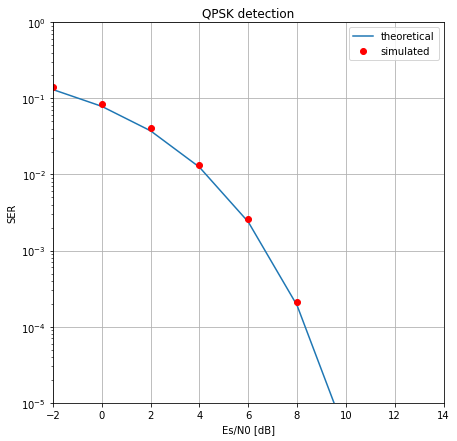

In [62]:
# Plot Es/N0 versus SER values.
fig = plt.figure(figsize=(7,7))
plt.plot(EsN0dB, ser_theo, label='theoretical')
plt.plot(EsN0dB, ser_simu, 'ro', label='simulated')
plt.xscale('linear')
plt.yscale('log')
plt.xlabel('Es/N0 [dB]')
plt.ylabel('SER')
plt.grid(True)
plt.title('QPSK detection')
plt.legend()
plt.xlim([-2, 14])
plt.ylim([1e-5, 1])
plt.show()

**C. Podemos dizer que a curva simulada se aproxima da curva teórica da SER?**

R: Sim, podemos dizer que a curva simulada se aproxima da teórica da SER.